<a href="https://colab.research.google.com/github/rabihchamas/Classifier-Aligner/blob/main/ClassifierAlignerNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net,self).__init__()
#         self.linear1 = nn.Linear(28*28, 100) 
#         self.linear2 = nn.Linear(100, 50) 
#         self.final = nn.Linear(50, 10)
#         self.relu = nn.ReLU()

#     def forward(self, img): #convert + flatten
#         x = img.view(-1, 28*28)
#         x = self.relu(self.linear1(x))
#         x = self.relu(self.linear2(x))
#         x = self.final(x)
#         return x
# net = Net()

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import math
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torch.nn import Transformer
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
import torch


def shuffleIm(tensor):
  for i in range(tensor.shape[0]):
    indexes = torch.randperm(tensor.shape[1])
    tensor[i] = tensor[i][indexes]
  return tensor  


In [ ]:
# t = torch.tensor([[1, 2,3], [4,5,6]])
# t1 = t.reshape(3,2)
# t = t.transpose(0,1)
# print(t1)
# print(t)
#torch.gather(t, 0, torch.tensor([[0, 0], [1, 0]]))

In [ ]:
# #x = x.transpose(1,2)
# print(w.shape)
# w=w[:, 1, :]
# print(w.shape)
# print(w)

In [ ]:
# Define the architecture of the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='valid')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='valid')
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

In [ ]:
# out=F.pad(output,(50,50))
# out=out.reshape(64,1,110)
# print(out.shape)

In [ ]:
#x = x.view(64,-1)

In [ ]:
# linear1 = nn.Linear(28*28, 110)
# relu = nn.ReLU()

In [ ]:
# x = relu(linear1(x))
# x=x.reshape(64,1,110)

In [ ]:
# n=torch.cat((out,x),1)
# print(n.shape)

In [ ]:
class EmbedLayer(nn.Module):
    def __init__(self):
        super(EmbedLayer, self).__init__()
        #self.args = args
       # self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=4)  # Pixel Encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 6), requires_grad=True)  # Cls Token
        self.pos_embedding = nn.Parameter(torch.zeros(1, 111, 6), requires_grad=True)  # Positional Embedding

    def forward(self, x):
       # x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P
        x = x.reshape([x.shape[0], 6, -1])  # B E IH/P IW/P -> B E S
        x = x.transpose(1, 2)  # B E S -> B S E
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)
        x = x + self.pos_embedding
        return x

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.n_attention_heads = 6
        self.embed_dim = 6
        self.head_embed_dim = self.embed_dim // self.n_attention_heads

        self.queries = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)
        self.keys = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)
        self.values = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)

        self.fc = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, q, k, v):

        x_queries = self.queries(q).reshape(q.shape[0], q.shape[1], self.n_attention_heads, self.head_embed_dim)  # B, Q, E -> B, Q, H, HE
        x_queries = x_queries.transpose(1, 2)  # B, Q, H, HE -> B, H, Q, HE
        x_keys = self.keys(k).reshape(k.shape[0], k.shape[1], self.n_attention_heads, self.head_embed_dim)  # B, K, E -> B, K, H, HE
        x_keys = x_keys.transpose(1, 2)  # B, K, H, HE -> B, H, K, HE
        x_values = self.values(v).reshape(v.shape[0], v.shape[1], self.n_attention_heads, self.head_embed_dim)  # B, V, E -> B, V, H, HE
        x_values = x_values.transpose(1, 2)  # B, V, H, HE -> B, H, V, HE

        x_queries = x_queries.reshape([-1, x_queries.shape[2], x_queries.shape[3]])  # B, H, Q, HE -> (BH), Q, HE
        x_keys = x_keys.reshape([-1, x_keys.shape[2], x_keys.shape[3]])  # B, H, K, HE -> (BH), K, HE
        x_values = x_values.reshape([-1, x_values.shape[2], x_values.shape[3]])  # B, H, V, HE -> (BH), V, HE

        x_keys = x_keys.transpose(1, 2)  # (BH), K, HE -> (BH), HE, K
        x_attention = x_queries.bmm(x_keys)  # (BH), Q, HE  .  (BH), HE, K -> (BH), Q, K
        x_attention = x_attention / (self.head_embed_dim ** 0.5)
        x_attention = torch.softmax(x_attention, dim=-1)

        x = x_attention.bmm(x_values)  # (BH), Q, K . (BH), V, HE -> (BH), Q, HE
        x = x.reshape([-1, self.n_attention_heads, x.shape[1], x.shape[2]])  # (BH), Q, HE -> B, H, Q, HE
        x = x.transpose(1, 2)  # B, H, Q, HE -> B, Q, H, HE
        x = x.reshape(x.shape[0], x.shape[1], -1)  # B, Q, H, HE -> B, Q, E
        return x

In [ ]:
# class Classifier(nn.Module):
#     def __init__(self, args):
#         super(Classifier, self).__init__()
#         self.fc1 = nn.Linear(args.embed_dim, args.embed_dim)
#         self.activation = nn.Tanh()
#         self.fc2 = nn.Linear(args.embed_dim, args.n_classes)

#     def forward(self, x):
#         x = x[:, 0, :]  # Get CLS token
#         x = self.fc1(x)
#         x = self.activation(x)
#         x = self.fc2(x)
#         return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.attention = AttentionLayer()
        self.fc1 = nn.Linear(6, 6 * 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(6 * 2, 6)
        self.norm1 = nn.LayerNorm(6)
        self.norm2 = nn.LayerNorm(6)

    def forward(self, x):
        x_ = self.attention(x, x, x)
        x = x + x_
        x = self.norm1(x)
        x_ = self.fc1(x)
        x = self.activation(x)
        x_ = self.fc2(x_)
        x = x + x_
        x = self.norm2(x)

        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super(VisionTransformer, self).__init__()
        self.embedding = EmbedLayer()
        self.encoder = nn.Sequential(*[Encoder() for _ in range(6)], nn.LayerNorm(6))
        self.encoder1 = nn.Sequential(nn.Linear(6, 3), nn.LayerNorm(3))
        self.decoder = torch.nn.Sequential(	torch.nn.Linear(111, 28 * 28),torch.nn.Sigmoid())
        #self.classifier = Classifier(args)

        # Intialization
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.encoder1(x)
        x = x.transpose(1,2)
        x = self.decoder(x)
        return x

In [ ]:
class CAN(nn.Module):
  def __init__(self):
    super(CAN,self).__init__()
    self.Classifier = Net()
    self.ImgEncoder = torch.nn.Sequential(torch.nn.Linear(28 * 28, 110),torch.nn.ReLU())
    self.Alighner = VisionTransformer()

  def forward(self,Im1,Im2,Im3):
    c1 = self.Classifier(Im1)
    c1=F.pad(c1,(50,50))
    c1=c1.reshape(64,1,110)
    c2 = self.Classifier(Im2)
    c2=F.pad(c2,(50,50))
    c2=c2.reshape(64,1,110)
    c3 = self.Classifier(Im3)
    c3=F.pad(c3,(50,50))
    c3=c3.reshape(64,1,110)
    c = torch.cat((c1,c2,c3),1)
    Imgs = torch.cat((Im1,Im2,Im3),1)
    Imgs = Imgs.reshape(64,3,-1)
    ShuffledImgs = shuffleIm(Imgs)
    ShuffledImgs = self.ImgEncoder(ShuffledImgs)
    input = torch.cat((c,ShuffledImgs),1)
    output = self.Alighner(input)
    return output

In [ ]:
# model =  CAN()

In [ ]:
# x = torch.rand(64,1,28,28)
# y = torch.rand(64,1,28,28)
# z = torch.rand(64,1,28,28)
# test = torch.rand(64,6,110)
# print(test.shape)

In [ ]:
#model1=VisionTransformer()
#b=model1(test)

In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
						train = True,
						download = True,
						transform = tensor_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
									batch_size = 64,
									shuffle = True)

In [ ]:
# Model Initialization
model = CAN().cuda()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-3,
							weight_decay = 1e-8)


In [ ]:
epochs = 50
#outputs = []
#losses = []
for epoch in range(epochs):
    print("epoch number", epoch)
    c=0
    Imgs = []
    for (image, _) in loader:
      Imgs.append(image)
      c = c+1
      if(c==3):
        Img1 = Imgs[0].cuda()
        Img2 = Imgs[1].cuda()
        Img3 = Imgs[2].cuda()
        Imgss = torch.cat((Img1,Img2,Img3),1)
        Imgss = Imgss.reshape(64,3,-1)
      # Reshaping the image to (-1, 784)
      #print(image.shape)
      #image = image.reshape(-1, 28*28)

      # Output of Autoencoder
        pred = model(Img1,Img2,Img3)
      #print(reconstructed)
       
      # Calculating the loss function
        loss = loss_function(pred, Imgss)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
      # Storing the losses in a list for plotting
        #losses.append(loss)
        print("the loss: ", loss)
        c = 0
        Imgs = []

    #outputs.append((epochs, image, reconstructed))

Streaming output truncated to the last 5000 lines.
the loss:  tensor(0.0483, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0484, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0494, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0492, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0478, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0467, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0498, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0498, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0477, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0492, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0456, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward0>)
the loss:  tensor(0.0486, 

In [ ]:
batch = next(iter(loader))


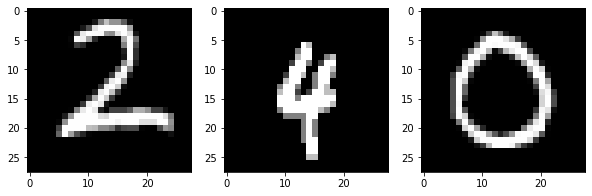

In [ ]:
# Get the first three images from the batch
images = batch[0][:3]

# Plot the images using matplotlib
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
for i, image in enumerate(images):
    axs[i].imshow(image.squeeze(), cmap='gray')
plt.show()

In [ ]:
Img1 = Imgs[0].cuda()
Img2 = Imgs[1].cuda()
Img3 = Imgs[2].cuda()
Imgss = torch.cat((Img1,Img2,Img3),1)
Imgss = Imgss.reshape(64,3,-1)
# Reshaping the image to (-1, 784)
#print(image.shape)
#image = image.reshape(-1, 28*28)

# Output of Autoencoder
pred = model(Img1,Img2,Img3)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


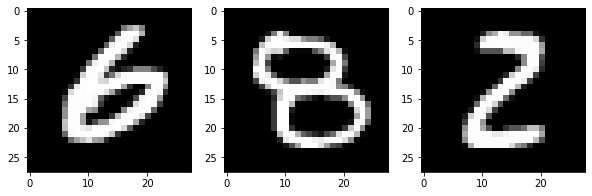

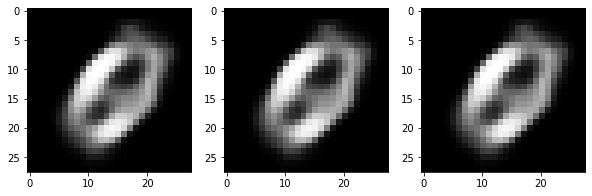

In [ ]:
#Imgss=[]
c=0
for (image, _) in loader:
  print(image.shape)
  Imgs.append(image)
  c = c+1
  if(c==10):
    Img1 = Imgs[7]
    Img2 = Imgs[8]
    Img3 = Imgs[9]
    # Imgss = torch.cat((Img1,Img2,Img3),1)
    # Imgss = Imgss.reshape(64,3,-1)
    break
  # Reshaping the image to (-1, 784)
  #print(image.shape)
  #image = image.reshape(-1, 28*28)

Imgss = torch.cat((Img1,Img2,Img3),1)
Imgss = Imgss[0]
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
for i, image in enumerate(Imgss):
    axs[i].imshow(image.squeeze(), cmap='gray')
plt.show()
model.cpu()
with torch.no_grad():
    pred = model(Img1,Img2,Img3)
#pred = model(Img1,Img2,Img3)
pim1 = pred[0][0]
pim1 = pim1.reshape(1,28,28)
pim2 = pred[0][1]
pim2 = pim1.reshape(1,28,28)
pim3 = pred[0][2]
pim3 = pim1.reshape(1,28,28)
predimgs=[pim1,pim2,pim3]
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
for i, image in enumerate(predimgs):
    axs[i].imshow(image.squeeze(), cmap='gray')
plt.show()
#generatedImgs = pred[0][:3]

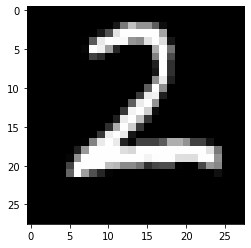

In [ ]:
plt.imshow(image.squeeze(), cmap='gray')
plt.show()